# Importing Libraries

pip install yfinance

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from arch import arch_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings("ignore")

# Importing Dataset

We will be importing our data for oil prices of 01 January 2010 until 31 December 2023 using yfinance 

In [3]:
oil_data = yf.download('CL=F', start='2015-01-01', end='2023-12-31')
oil_data['returns'] = oil_data['Adj Close'].pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


In [4]:
oil_data.head()

,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,
2015-01-02,53.759998,55.110001,52.029999,52.689999,52.689999,268708,NaN
2015-01-05,52.610001,52.730000,49.680000,50.040001,50.040001,375782,-0.050294
2015-01-06,50.000000,50.369999,47.549999,47.930000,47.930000,451642,-0.042166
2015-01-07,48.000000,49.310001,46.830002,48.650002,48.650002,460083,0.015022
2015-01-08,48.779999,49.650002,47.730000,48.790001,48.790001,362081,0.002878


Creating a dummy variable for the intervention for COVID-19 starting from March 2020 when the Global Lockdown took place

**Temporary Shock**

In [5]:
oil_data['covid_temp'] = 0
oil_data.loc['2020-03-01':'2020-06-30', 'covid_temp'] = 1  # Temporary shock period

# Visualising the data

In [6]:
import mplfinance as mpl

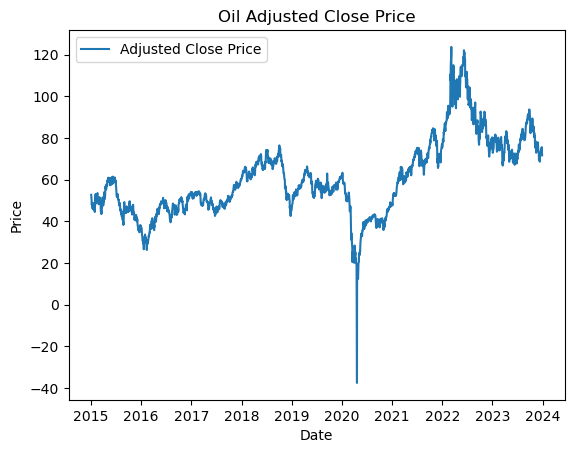

In [7]:

plt.plot(oil_data['Adj Close'], label='Adjusted Close Price')
plt.title('Oil Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

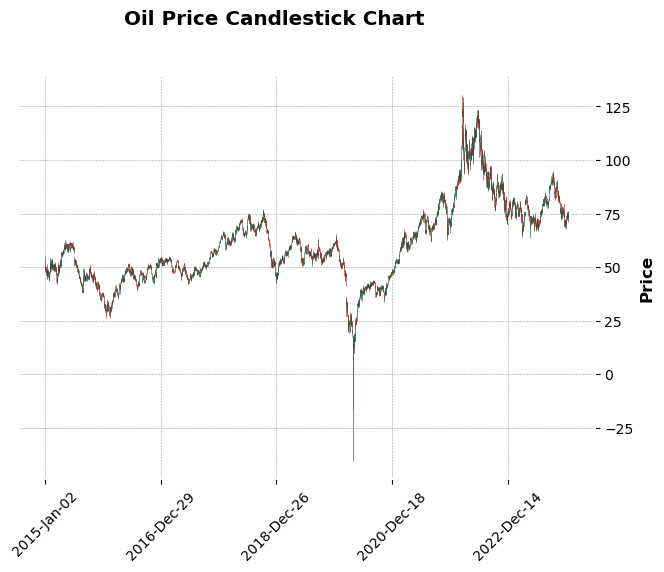

In [8]:
mpl.plot(oil_data, type='candle', style='charles', title='Oil Price Candlestick Chart', 
         ylabel='Price', volume=False, show_nontrading=False)

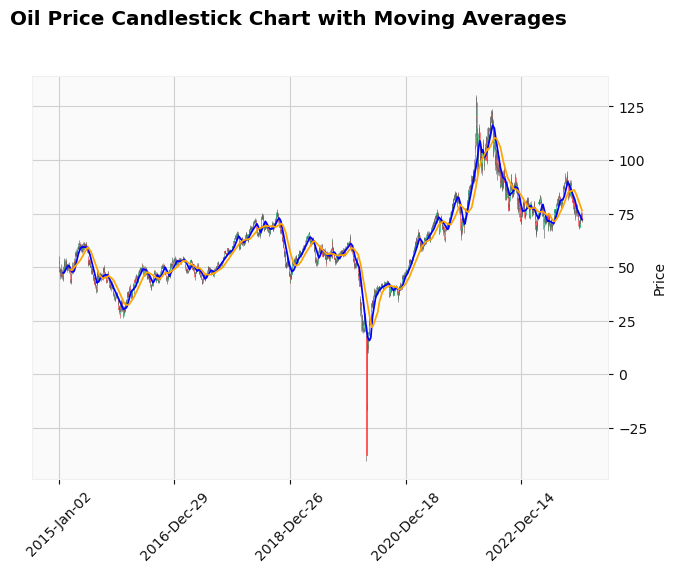

In [9]:
# Define moving averages
add_plot = [
    mpl.make_addplot(oil_data['Adj Close'].rolling(window=20).mean(), color='blue', linestyle='-'),
    mpl.make_addplot(oil_data['Adj Close'].rolling(window=50).mean(), color='orange', linestyle='-')
]

# Plot with moving averages
mpl.plot(oil_data, type='candle', style='yahoo', title='Oil Price Candlestick Chart with Moving Averages', 
         ylabel='Price', volume=False, addplot=add_plot, show_nontrading=False)


# Plotting the ACF and PACF

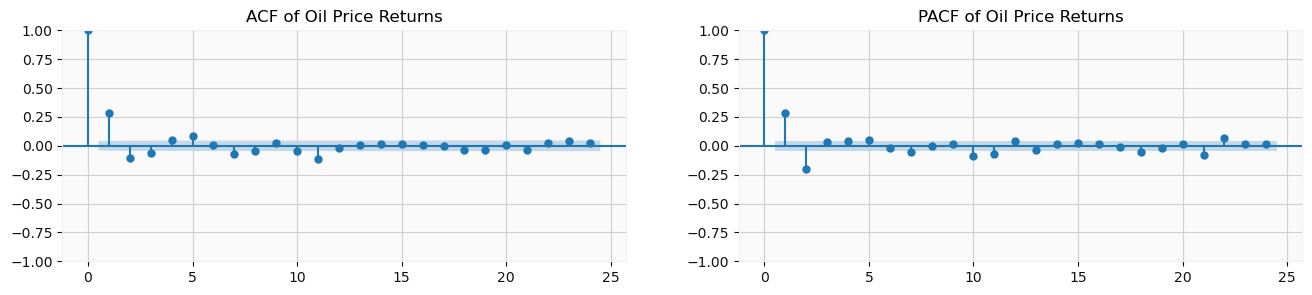

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

# ACF plot
sm.graphics.tsa.plot_acf(oil_data['returns'].dropna(), lags=24, ax=axes[0])
axes[0].set_title('ACF of Oil Price Returns')

# PACF plot
sm.graphics.tsa.plot_pacf(oil_data['returns'].dropna(), lags=24, ax=axes[1])
axes[1].set_title('PACF of Oil Price Returns')

plt.show()

# Fitting the GARCH Model

Fitting the GARCH Model with a temporary Shock

In [11]:
garch_temp = arch_model(oil_data['returns'].dropna(), vol='Garch', p=1, q=1, mean='constant', x=oil_data[['covid_temp']].dropna())
fitted_garch_temp = garch_temp.fit(disp='off')
print("Temporary Intervention Model Summary")
print(fitted_garch_temp.summary())

Temporary Intervention Model Summary
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4225.03
Distribution:                  Normal   AIC:                          -8442.05
Method:            Maximum Likelihood   BIC:                          -8419.16
                                        No. Observations:                 2262
Date:                Thu, May 23 2024   Df Residuals:                     2261
Time:                        01:45:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.4700e

# Testing for ARCH Effects

In [12]:
returns = oil_data['returns'].dropna()

In [13]:
from statsmodels.stats.diagnostic import het_arch

test = het_arch(returns)

In [14]:
arch_statistic, p_value, _, _ = test

print(f"ARCH Test Statistic: {arch_statistic}")
print(f"P-value: {p_value}")

ARCH Test Statistic: 64.9407505261577
P-value: 4.160460037236668e-10


In [15]:
if p_value < 0.05:
    print("There is evidence of ARCH effects in the returns.")
else:
    print("There is no evidence of ARCH effects in the returns.")

There is evidence of ARCH effects in the returns.


# Data Visualisation

We will be plotting the Temporary and Permanent Shocks

Plot for the Temporary Shock

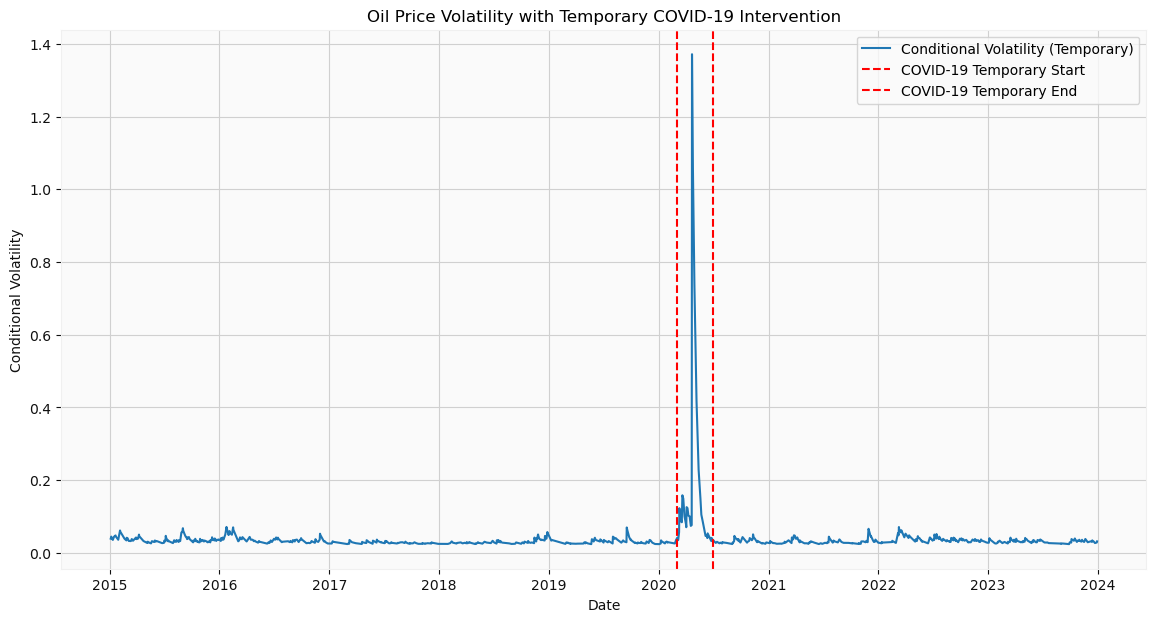

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(fitted_garch_temp.conditional_volatility, label='Conditional Volatility (Temporary)')
plt.axvline(pd.Timestamp('2020-03-01'), color='r', linestyle='--', label='COVID-19 Temporary Start')
plt.axvline(pd.Timestamp('2020-06-30'), color='r', linestyle='--', label='COVID-19 Temporary End')
plt.title('Oil Price Volatility with Temporary COVID-19 Intervention')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.legend()
plt.show()

# ARCH Effects 

We will be performing the the Augmented Dickey-Fuller test and the Engel's test to observe our model for ARCH Effects 

**ADFULLER**

I will be using the Augmented Dickey-Fuller test to check for stationarity


In [20]:
from statsmodels.tsa.stattools import adfuller

In [22]:
# Perform the ADF test
stationarity = adfuller(returns)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if stationarity[1] > 0.05:
    print("The series is non-stationary. Differencing is needed.")
    stationarity_diff = stationarity.diff().dropna()
else:
    print("The series is stationary.")


ADF Statistic: -10.936251651074752
p-value: 9.543491362693101e-20
The series is stationary.


In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [25]:
returns_diff = returns.diff().dropna()

In [26]:
# Fit the GARCH model
model = arch_model(returns_diff, vol='Garch', p=1, q=1)
model_fit = model.fit()

# Get residuals
residuals = model_fit.resid

# Perform Ljung-Box test
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_result)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 7047776784.624807
Iteration:      2,   Func. Count:     18,   Neg. LLF: 552347.9481476378
Iteration:      3,   Func. Count:     30,   Neg. LLF: 6767.247312511407
Iteration:      4,   Func. Count:     39,   Neg. LLF: 8808947.684556825
Iteration:      5,   Func. Count:     51,   Neg. LLF: 79301.99428487151
Iteration:      6,   Func. Count:     63,   Neg. LLF: 6189.093195080786
Iteration:      7,   Func. Count:     72,   Neg. LLF: -3923.120875700702
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3923.120858733918
            Iterations: 11
            Function evaluations: 72
            Gradient evaluations: 7
       lb_stat     lb_pvalue
10  381.402327  8.509344e-76


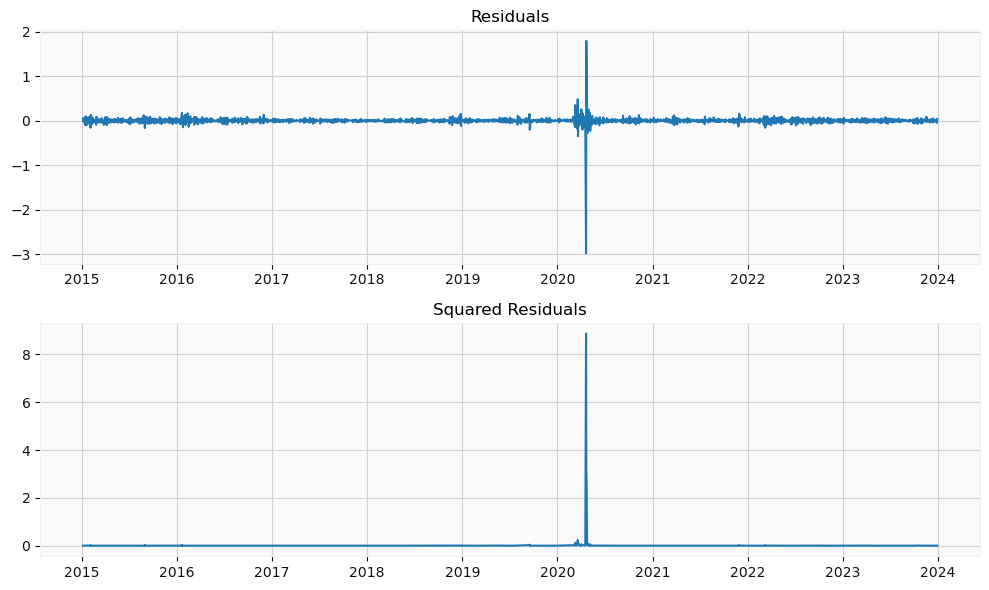

In [27]:
import matplotlib.pyplot as plt

# Plot residuals and squared residuals
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(residuals)
ax[0].set_title('Residuals')
ax[1].plot(residuals**2)
ax[1].set_title('Squared Residuals')
plt.tight_layout()
plt.show()


In [67]:
log_returns = np.log(oil_data / oil_data.shift(1)).dropna()

Model diagnostics: Check residuals

In [44]:
 residuals = model_fit.resid

Performing the Engle's test

In [63]:
from statsmodels.stats.diagnostic import acorr_lm

arch_test = acorr_lm(residuals, nlags=1)
print(arch_test)


(120.49632368439248, 4.925798051149202e-28, 127.17000764770944, 9.845569191007093e-29)


# Forecasting

We will now forecast our model using the temporary shock

Forecasting

In [45]:
forecast = model_fit.forecast(horizon=len(test))
forecast_mean = forecast.mean.values[-1, :]

Evaluate forecast

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3148582866122.0703
Iteration:      2,   Func. Count:     21,   Neg. LLF: 823469092233.3489
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1823832726576.304
Iteration:      4,   Func. Count:     48,   Neg. LLF: -3549.590145161836
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3549.590101907134
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 4


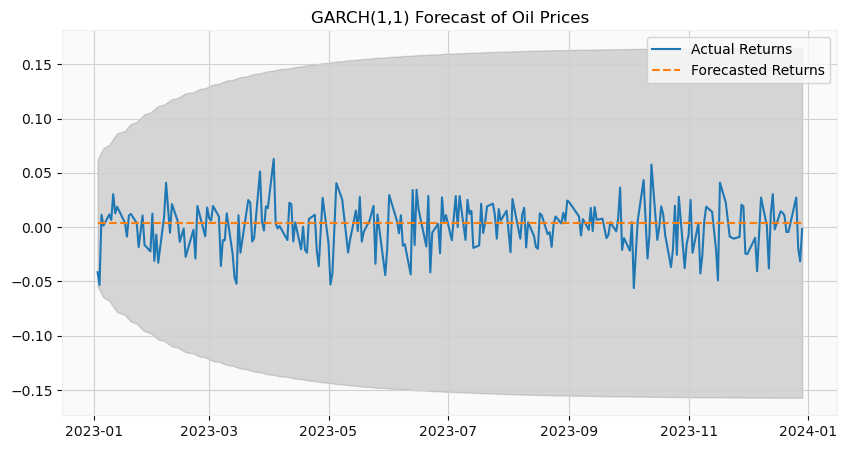

In [64]:
# Split data into training and test sets
train = returns['2015-03-01':'2022-12-31']
test = returns['2023-01-01':'2023-12-31']

# Fit GARCH(1,1) model
model = arch_model(train, vol='Garch', p=1, q=1)
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(horizon=len(test))
forecast_variance = forecast.variance.values[-1, :]
forecast_mean = forecast.mean.values[-1, :]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual Returns')
plt.plot(test.index, forecast_mean, label='Forecasted Returns', linestyle='--')
plt.fill_between(test.index, forecast_mean - 2*np.sqrt(forecast_variance),
                 forecast_mean + 2*np.sqrt(forecast_variance), color='gray', alpha=0.3)
plt.legend()
plt.title('GARCH(1,1) Forecast of Oil Prices')
plt.show()


# Evaluating Model Performance

I used the MSE and MAE to check the model's performance

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generate forecasts
forecast = model_fit.forecast(horizon=len(test))
forecast_mean = forecast.mean.values[-1, :]

# Evaluate forecast
mse = mean_squared_error(test, forecast_mean)
mae = mean_absolute_error(test, forecast_mean)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 1065.3756689008774
Mean Absolute Error: 17.898748208927685
